Data : https://www.statmt.org/ (see european parlaiment proceedings)

REFERENCE: https://arxiv.org/abs/1706.03762

Got help : [here](https://github.com/rasbt/machine-learning-book/blob/main/ch15/ch15_part2.ipynb) and [here](https://github.com/dksifoua/Neural-Machine-Translation/blob/master/notebooks/5%20-%20SeqToSeq%20Model%20with%20Transformer.ipynb)

In [116]:
import random
import re
import string
import unicodedata
import tqdm
import pickle
from pickle import dump, load
from collections import Counter, OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, DataLoader

import torchtext
from torchtext.vocab import vocab
from torchtext.data.metrics import bleu_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!wget -q https://www.statmt.org/europarl/v7/fr-en.tgz
!tar -xf fr-en.tgz

In [ ]:
#@title preprocess raw data

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# split a loaded document into sentences
def to_sentences(doc):
    return doc.strip().split('\n')

# shortest and longest sentence lengths
def sentence_lengths(sentences):
    lengths = [len(s.split()) for s in sentences]
    return min(lengths), max(lengths)

# clean lines
def clean_lines(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # normalize unicode characters
        line = unicodedata.normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # tokenize on white space
        line = line.split()
        # convert to lower case
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [word.translate(table) for word in line]
        # remove non-printable chars form each token
        line = [re_print.sub('', w) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        cleaned.append(' '.join(line))
    return cleaned

# load English data
filename = 'europarl-v7.fr-en.en'
doc = load_doc(filename)
sentences = to_sentences(doc)
minlen, maxlen = sentence_lengths(sentences)
print('English data: sentences=%d, min=%d, max=%d' % (len(sentences),
minlen, maxlen))
cleanf=clean_lines(sentences)
filename = 'English.pkl'

with open(filename,'wb') as fl:
  outfile = fl
  pickle.dump(cleanf,outfile)
#outfile.close()             #do this with context manager
  print(filename," saved")

# load French data
filename = 'europarl-v7.fr-en.fr'
doc = load_doc(filename)
sentences = to_sentences(doc)
minlen, maxlen = sentence_lengths(sentences)
print('French data: sentences=%d, min=%d, max=%d' % (len(sentences),
minlen, maxlen))
cleanf=clean_lines(sentences)
filename = 'French.pkl'
with open(filename,'wb') as fl:
  outfile = fl
  pickle.dump(cleanf,outfile)
  print(filename," saved")

# load a clean dataset
def load_clean_sentences(filename):
    with open(filename, 'rb') as fl:
      loaded = load(fl)
    return loaded

# save a list of clean sentences to file
def save_clean_sentences(sentences, filename):
    with open(filename, 'wb') as fl:
        dump(sentences, fl)
        print('Saved: %s' % filename)

# create a frequency table for all words
def to_vocab(lines):
    vocab = Counter()
    for line in lines:
        tokens = line.split()
        vocab.update(tokens)
    return vocab

# remove all words with a frequency below a threshold
def trim_vocab(vocab, min_occurance):
    tokens = [k for k,c in vocab.items() if c >= min_occurance]
    return set(tokens)

# mark all out-of-vocabulary words with "unk" for all lines
def update_dataset(lines, vocab):
    new_lines = list()
    for line in lines:
        new_tokens = list()
        for token in line.split():

           if token in vocab:
              new_tokens.append(token)
           else:
              new_tokens.append('unk')
        new_line = ' '.join(new_tokens)
        new_lines.append(new_line)
    return new_lines


## load English dataset
filename = 'English.pkl'
lines = load_clean_sentences(filename)
# calculate vocabulary
vocab = to_vocab(lines)
print('English Vocabulary: %d' % len(vocab))
# reduce vocabulary
vocab = trim_vocab(vocab, 5)
print('New English Vocabulary: %d' % len(vocab))
# mark out of vocabulary words
lines = update_dataset(lines, vocab)
# save updated dataset
filename = 'english_vocab.pkl'
save_clean_sentences(lines, filename)
# spot check
for i in range(20):
    print("line",i,":",lines[i])


## load French dataset
filename = 'French.pkl'
lines = load_clean_sentences(filename)
# calculate vocabulary
vocab = to_vocab(lines)
print('French Vocabulary: %d' % len(vocab))
# reduce vocabulary
vocab = trim_vocab(vocab, 5)
print('New French Vocabulary: %d' % len(vocab))
# mark out of vocabulary words
lines = update_dataset(lines, vocab)
# save updated dataset
filename = 'french_vocab.pkl'
save_clean_sentences(lines, filename)
# spot check
for i in range(20):
    print("line",i,":",lines[i])


###----------------------------------------------------
# ff = 'french_vocab.pkl'
# french_lines = load_clean_sentences(ff)
#french_vocab = to_vocab(french_lines)
#print('French Vocabulary: %d' % len(french_vocab))

# ef = 'english_vocab.pkl'
# english_lines = load_clean_sentences(ef)
#english_vocab = to_vocab(english_lines)
#print('english Vocabulary: %d' % len(english_vocab))

#print([english_vocab[token] for token in ['this', 'is', 'an', 'example']]) 

In [39]:
#@title custom dataset and dataloader

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized

# to_vocab() is unsorted so not to do same thing twice integrate this into to_vocab function above 
def sorted_tokentoint(lines):
    token_vocab = Counter()
    for line in lines:
        tokens = tokenizer(line)
        token_vocab.update(tokens)
    sorted_by_freq_tuples = sorted(token_vocab.items(), key=lambda x: x[1], reverse=True)
    ordered_dict = OrderedDict(sorted_by_freq_tuples)
    vocab = torchtext.vocab.vocab(ordered_dict)
    vocab.insert_token("<pad>", 0)
    vocab.insert_token("<unk>", 1)
    vocab.insert_token("<sos>", 2)
    vocab.insert_token("<eos>", 3)
    vocab.set_default_index(1)    # for out of vocabulary words
    return vocab


ef = 'english_vocab.pkl'
english_lines = load_clean_sentences(ef)
ff = 'french_vocab.pkl'
french_lines = load_clean_sentences(ff)

sorted_french_vocab = sorted_tokentoint(french_lines)
sorted_english_vocab = sorted_tokentoint(english_lines)

# text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
def text_pipeline(text, language_vocab):
    return [language_vocab[token] for token in tokenizer(text)]

def collate_batch(batch):
    textin_list, textout_list, lengthsin, lengthsout = [], [], [], []
    for _textin, _textout in batch:
        _textin = '<sos> '+_textin +' <eos>'
        _textout = '<sos> '+_textout+' <eos>'
        processed_textin = torch.tensor(text_pipeline(_textin, sorted_english_vocab), 
                                      dtype=torch.int64)
        processed_textout = torch.tensor(text_pipeline(_textout, sorted_french_vocab), 
                                      dtype=torch.int64)
       
        textin_list.append(processed_textin)
        textout_list.append(processed_textout)
        # lengthsin.append(processed_textin.size(0))
        # lengthsout.append(processed_textout.size(0))

    # lengthsin = torch.tensor(lengthsin)
    # lengthsout = torch.tensor(lengthsout)

    padded_textin_list = nn.utils.rnn.pad_sequence(
        textin_list, batch_first=True)
    padded_textout_list = nn.utils.rnn.pad_sequence(
        textout_list, batch_first=True)
    
    return padded_textin_list.to(device), padded_textout_list.to(device) 
    #, lengthsin.to(device), lengthsout.to(device)


class TranslationDataset(Dataset):
    def __init__(self, in_lang_lines, out_lang_lines, custom_test_length=None):
        super().__init__()
        self.in_lang_lines = in_lang_lines
        self.out_lang_lines = out_lang_lines
        self.custom_test_length = custom_test_length

    def __len__(self):
        assert self.out_lang_lines==self.out_lang_lines
        return len(self.out_lang_lines) if not self.custom_test_length else self.custom_test_length

    def __getitem__(self, idx):
        in_sentence = self.in_lang_lines[idx]  
        out_sentence = self.out_lang_lines[idx]  
        return  in_sentence, out_sentence       ###tokenizer(in_sentence), tokenizer(out_sentence)  



length = len(english_lines[:128])  ## note, for full scale learning you should remove [:128] everywhere
trn = int(length*0.8)
val = int(length*0.1)
tst = length - trn - val

dataset = TranslationDataset(english_lines[:128], french_lines[:128], custom_test_length=128) ##remove 128 for full scale learning
torch.manual_seed(1)
train_dataset, valid_dataset, test_dataset = random_split(list(dataset), [trn, val, tst])

batch_size = 64  
train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)   #, drop_last=True
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

In [5]:
#@title multihead attention

class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, d_model, n_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        :param Tensor[batch_size, q_len, d_model] query
        :param Tensor[batch_size, k_len, d_model] key
        :param Tensor[batch_size, v_len, d_model] value
        :param Tensor[batch_size, ..., k_len] mask
        :return Tensor[batch_size, q_len, d_model] context
        :return Tensor[batch_size, n_heads, q_len, k_len] attention_weights
        """
        Q = self.fc_q(query) # [batch_size, q_len, d_model]
        K = self.fc_k(key) # [batch_size, k_len, d_model]
        V = self.fc_v(value) # [batch_size, v_len, d_model]

        Q = Q.view(Q.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, q_len, head_size]
        K = K.view(K.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, k_len, head_size]
        V = V.view(V.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, v_len, head_size]

        scores = torch.matmul(Q, K.transpose(-1, -2)) # [batch_size, n_heads, q_len, k_len]
        scores = scores / torch.sqrt(torch.FloatTensor([self.head_size]).to(Q.device))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e18)  # also see https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_
        attention_weights = F.softmax(scores , dim=-1) # [batch_size, n_heads, q_len, k_len]                
        
        context = torch.matmul(attention_weights, V) # [batch_size, n_heads, q_len, v_len]
        context = context.permute(0, 2, 1, 3).contiguous() # [batch_size, q_len, n_heads, v_len]
        context = context.view(context.size(0), -1, self.d_model)
        context = self.fc_o(context) # [batch_size, q_len, d_model]

        return context, attention_weights

In [ ]:
#@title positionwise feedforward and positional encoding 

# positionwise feedforward

class PositionWiseFeedForwardLayer(nn.Module):
    
    def __init__(self, d_model, hidden_size):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.d_model = d_model
        self.hidden_size = hidden_size
        self.fc_in = nn.Linear(d_model, hidden_size)
        self.fc_ou = nn.Linear(hidden_size, d_model)
        
    def forward(self, inputs):
        """
        :param Tensor[batch_size, seq_len, d_model] inputs
        :return Tensor[batch_size, seq_len, d_model] outputs
        """
        outputs = F.relu(self.fc_in(inputs)) # [batch_size, seq_len, hidden_size]
        return self.fc_ou(outputs) # [batch_size, seq_len, d_model]

# positional encoding layer is designed for giving positional / sequential awarenes of the words in the sentence to the model

class PositionalEncodingLayer(nn.Module):
    
    def __init__(self, d_model, max_len=100):
        super(PositionalEncodingLayer, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
    
    def get_angles(self, positions, indexes):
        d_model_tensor = torch.FloatTensor([[self.d_model]]).to(positions.device) # to same device as positions (generally and d_model are made to be same)
        angle_rates = torch.pow(10000, (2 * (indexes // 2)) / d_model_tensor)   #torch.pow(input, exponent) takes pover 
        return positions / angle_rates

    def forward(self, input_sequences):
        """
        :param Tensor[batch_size, seq_len] input_sequences
        :return Tensor[batch_size, seq_len, d_model] position_encoding
        """
        positions = torch.arange(input_sequences.size(1)).unsqueeze(1).to(input_sequences.device) # [seq_len, 1]
        indexes = torch.arange(self.d_model).unsqueeze(0).to(input_sequences.device) # [1, d_model]
        angles = self.get_angles(positions, indexes) # [seq_len, d_model]
        angles[:, 0::2] = torch.sin(angles[:, 0::2]) # apply sin to even indices in the tensor; 2i
        angles[:, 1::2] = torch.cos(angles[:, 1::2]) # apply cos to odd indices in the tensor; 2i
        position_encoding = angles.unsqueeze(0).repeat(input_sequences.size(0), 1, 1) # [batch_size, seq_len, d_model]
        return position_encoding

pos_encoding = PositionalEncodingLayer(d_model=512)(torch.randint(100, size=(64, 50))).numpy()
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [7]:
#@title encoder block and layer

class EncoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(EncoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, src_inputs, src_mask):
        """
        :param Tensor[batch_size, src_len, d_model] src_inputs
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        context, _ = self.multi_head_attention_layer(query=src_inputs, key=src_inputs, value=src_inputs, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + src_inputs)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs

class EncoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.encoder_block_layers = nn.ModuleList([EncoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size,
                                                                     dropout=dropout) for _ in range(n_layers)])
    
    def forward(self, src_sequences, src_mask):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        token_embedded = self.token_embedding(src_sequences) # [batch_size, src_len, d_model]
        position_encoded = self.position_encoding(src_sequences) # [batch_size, src_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, src_len, d_model]
        for layer in self.encoder_block_layers:
            outputs = layer(src_inputs=outputs, src_mask=src_mask) # [batch_size, src_len, d_model]
        return outputs

In [8]:
#@title decoder block and layer

class DecoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(DecoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.mask_multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.mask_multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, dest_inputs, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len, d_model] dest_inputs
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size,  dest_len] dest_mask
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, dest_len, d_model] outputs
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        masked_context, _ = self.mask_multi_head_attention_layer(query=dest_inputs, key=dest_inputs, value=dest_inputs, mask=dest_mask)
        masked_context = self.mask_multi_head_attention_layer_norm(self.dropout(masked_context) + dest_inputs)
        
        context, attention_weights = self.multi_head_attention_layer(query=masked_context, key=src_encoded, value=src_encoded, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + masked_context)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs, attention_weights


class DecoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.decoder_block_layers = nn.ModuleList([DecoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size, dropout=dropout) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, dest_sequences, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len] dest_sequences
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size, dest_len, d_model] dest_mask
        :param Tensor[batch_size, src_len, d_model] src_mask
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        token_embedded = self.token_embedding(dest_sequences) # [batch_size, dest_len, d_model]
        position_encoded = self.position_encoding(dest_sequences) # [batch_size, dest_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, dest_len, d_model]
        for layer in self.decoder_block_layers:
            outputs, attention_weights = layer(dest_inputs=outputs, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        logits = self.fc(outputs)
        return logits, attention_weights

In [9]:
#@title combining all in one transformer model

class Transformer(nn.Module):
    
    def __init__(self, encoder, decoder, src_pad_index, dest_pad_index):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_index = src_pad_index
        self.dest_pad_index = dest_pad_index

    def make_src_mask(self, src_sequences):
        """Mask <pad> tokens.
        :param Tensor[batch_size, src_len] src_sequences
        :return Tensor[batch size, 1, 1, src len] src_mask
        """        
        src_mask = (src_sequences != self.src_pad_index).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_dest_mask(self, dest_sequences):
        """Mask <pad> tokens and future tokens as well.
        :param Tensor[batch_size, dest_len] dest_sequences
        :return tensor[batch_size, 1, dest_len, dest_len] dest_mask
        """
        mask = (dest_sequences != self.dest_pad_index).unsqueeze(1).unsqueeze(2) # [batch size, 1, 1, trg len]
        # torch.tril() lower triangular part of the matrix 
        sub_mask = torch.tril(torch.ones((dest_sequences.size(1), dest_sequences.size(1))).to(dest_sequences.device)).bool() # [trg len, trg len]        
        return mask & sub_mask      #both hold for masking: mask--> true everywhere except dest_pad_index; sub_mask-->'triangular' filter
    
    def forward(self, src_sequences, dest_sequences):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, dest_len] dest_sequences
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        src_mask, dest_mask = self.make_src_mask(src_sequences), self.make_dest_mask(dest_sequences)
        src_encoded = self.encoder(src_sequences=src_sequences, src_mask=src_mask)
        logits, attention_weights = self.decoder(dest_sequences=dest_sequences, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        return logits, attention_weights

In [41]:
#@title building parts for training

class Metrics:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

def accuracy(outputs, target_sequences, k=5):
    """ Calculate Top-k accuracy
    :param Tensor[batch_size, dest_seq_len, vocab_size] outputs
    :param Tensor[batch_size, dest_seq_len] target_sequences
    :return float Top-k accuracy
    """
    batch_size = target_sequences.size(0)
    _, indices = outputs.topk(k, dim=2, largest=True, sorted=True) # [batch_size, dest_seq_len, 5]  #also see torch.topk() https://pytorch.org/docs/stable/generated/torch.topk.html
    correct = indices.eq(target_sequences.unsqueeze(-1).expand_as(indices))  #also see torch.eq() https://pytorch.org/docs/stable/generated/torch.eq.html
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / indices.numel())


class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
    
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker, acc_tracker = Metrics(), Metrics()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            src, trg = batch[0], batch[1]
            self.optimizer.zero_grad()
            logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
            loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            acc_tracker.update(accuracy(logits, trg[:, 1:]))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker, acc_tracker = Metrics(), Metrics()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                src, trg = batch[0], batch[1]
                logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
                loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
                loss_tracker.update(loss.item())
                acc_tracker.update(accuracy(logits, trg[:, 1:]))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip):
        history, best_loss = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': [], 'ppl': [], 'val_ppl': []}, np.inf
        for epoch in range(n_epochs):
            loss, ppl, acc = self.train_step(train_loader, epoch, grad_clip)
            val_loss, val_ppl, val_acc = self.validate(valid_loader, epoch)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), './transformer.pth')
            history['acc'].append(acc); history['val_acc'].append(val_acc)
            history['ppl'].append(ppl); history['val_ppl'].append(val_ppl)
            history['loss'].append(loss); history['val_loss'].append(val_loss)
        return history

In [ ]:
#@title training

D_MODEL = 256
N_LAYERS = 2
N_HEADS = 8
HIDDEN_SIZE = 512
MAX_LEN = 50
DROPOUT = 0.25
BATCH_SIZE = 64
LR = 1e-3
N_EPOCHS = 10
GRAD_CLIP = 1.0


transformer = Transformer(
    encoder=EncoderLayer(
        vocab_size=len(sorted_english_vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    decoder=DecoderLayer(
        vocab_size=len(sorted_french_vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    src_pad_index= 0, #after using torch.nn.utils.rnn.pad_sequence() the default value for padded element == 0 
    dest_pad_index= 0, 
).to(device)
optimizer = optim.Adam(params=transformer.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss(ignore_index=0) 
# print(f'Number of parameters of the model: {sum(p.numel() for p in transformer.parameters() if p.requires_grad):,}')
# print(transformer)
trainer = Trainer(model=transformer, optimizer=optimizer, criterion=criterion)


history = trainer.train(train_loader=train_dl, valid_loader=valid_dl, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

### visualize training results
titlelist = ['Loss', 'Perplexity', 'Top-5 Accuracy & BLEU-4']
eval_type_list = ['Loss', 'Perplexity', 'Accuracy & BLEU-4 (%)']
def plot(titlelist, eval_type_list):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        a, b = list(history.keys())[:i+2][-2:]
        axes[i].plot(history[a], label='train')
        axes[i].plot(history[b], label='valid')
        axes[i].set_title(titlelist[i])
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(eval_type_list[i])
        axes[i].grid(True)
        axes[i].legend();
    plt.show()

plot(titlelist, eval_type_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


input = good morning world
output = de de de de de


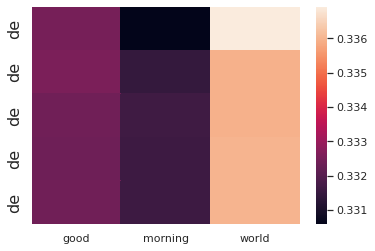

In [159]:
#@title translate and test

transformer = Transformer(
    encoder=EncoderLayer(
        vocab_size=len(sorted_english_vocab),
        max_len=50,
        d_model=256,
        n_heads=8,
        hidden_size=512,
        dropout=0.25,
        n_layers=2
    ),
    decoder=DecoderLayer(
        vocab_size=len(sorted_french_vocab),
        max_len=50,
        d_model=256,
        n_heads=8,
        hidden_size=512,
        dropout=0.25,
        n_layers=2
    ),
    src_pad_index= 0, 
    dest_pad_index= 0, 
).to(device)

transformer.load_state_dict(torch.load('./transformer.pth'))
transformer.to(device)


def visualize_attention(attentions, inputtext, outputtext):
  np.random.seed(0)
  sns.set_theme()
  xticks = inputtext.split(' ')                         #[''] + inputtext.split(' ') + ['<eos>']
  outputtext = outputtext.split(' ')
  ax = sns.heatmap(attentions.cpu().detach().numpy(), xticklabels=xticks, yticklabels=outputtext)
  ax.set_yticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 16)
  print('input =', inputtext)
  print('output =', ' '.join(outputtext))


def translate(sentence, model=transformer, max_len=5, device=device):

    src_sequence = text_pipeline(sentence, sorted_english_vocab)

    translated_sentence, attention_weights, pred_logps = [], [], []
    model.eval()
    with torch.no_grad():
        
        src_sequence = torch.LongTensor(src_sequence).unsqueeze(0).to(device)
        src_mask = model.make_src_mask(src_sequence)
        src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)
        predicted = [sorted_english_vocab['<sos>']]

        for i in range(max_len):   
            already_translated = torch.LongTensor(predicted).unsqueeze(0).to(device)
            dest_mask = model.make_dest_mask(already_translated)
            logit, attn_weights = model.decoder(dest_sequences=already_translated, src_encoded=src_encoded,
                                      dest_mask=dest_mask, src_mask=src_mask) # [1, dest_seq_len, vocab_size]                      
            logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
            
            # this part should be removed when model predicts well as it is not necessary
            if torch.argmax(logp)==sorted_french_vocab['<pad>']:
                logp[sorted_french_vocab['<pad>']] = -float('inf')
            #----------------------------------------------------------------------------

            predicted_token = torch.argmax(logp)                  
            if predicted_token.cpu().item()==sorted_french_vocab['<eos>']: 
                break
            else:
              predicted.append(predicted_token.cpu().item())

    translation = ' '.join(sorted_french_vocab.lookup_tokens(predicted[1:])) # I generally avoid using vocab functionalities, but this time let it be so
    attention = torch.mean(attn_weights.squeeze(0), dim=0)    #you can average across all attention head results
    #attention = attn_weights[0][random.choice(range(N_HEADS))]  #randomly choose one of 8 attention head results

    return visualize_attention(attention, sentence, translation)           

translate('good morning world')